In [1]:
import torch
import torch.nn as nn
import snntorch as snn
import numpy as np
# from snntorch import export
import nir
import nirtorch

In [2]:
graph = nir.read('lif_norse.nir')
graph.nodes

{'0': Affine(weight=array([[1.]], dtype=float32), bias=array([0.], dtype=float32)),
 '1': LIF(tau=array([0.0025], dtype=float32), r=array([1.], dtype=float32), v_leak=array([0.], dtype=float32), v_threshold=array([0.1], dtype=float32)),
 'input': Input(input_type={'input': array([1])}),
 'output': Output(output_type={'output': array([1])})}

In [3]:
net = snn.import_from_nir(graph)

replace rnn subgraph with nirgraph
[warning] scaling weights to avoid scaling inputs
w_scale: [0.04], r: [1.], dt: 0.0001, tau: [0.0025]


In [4]:
isis = [
    6, 15, 4, 3, 0, 2, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 14
]
d1 = list(np.concatenate([isi*[0]+[1] for isi in isis]))[:100]
d = np.array([[e] + 9*[0] for e in d1]).reshape(1, -1)

In [5]:
[e.elem for e in net.get_execution_order()], [e.name for e in net.get_execution_order()]

([Identity(),
  Linear(in_features=1, out_features=1, bias=True),
  Leaky(),
  Identity()],
 ['input', '0', '1', 'output'])

In [6]:
d = torch.Tensor(d)
hstate = nirtorch.from_nir.GraphExecutorState(
    state={
        '1': net._modules['1'].init_leaky()
    }
)
spk_arr = []
mem_arr = []
for t in range(d.shape[1]):
    spk, hstate = net.forward(d[:, t], hstate)
    mem_state = hstate.state['1'][0].detach().numpy().item()
    spk_arr.append(spk.detach().numpy().item())
    mem_arr.append(mem_state)
spk_arr = np.array(spk_arr)
mem_arr = np.array(mem_arr)

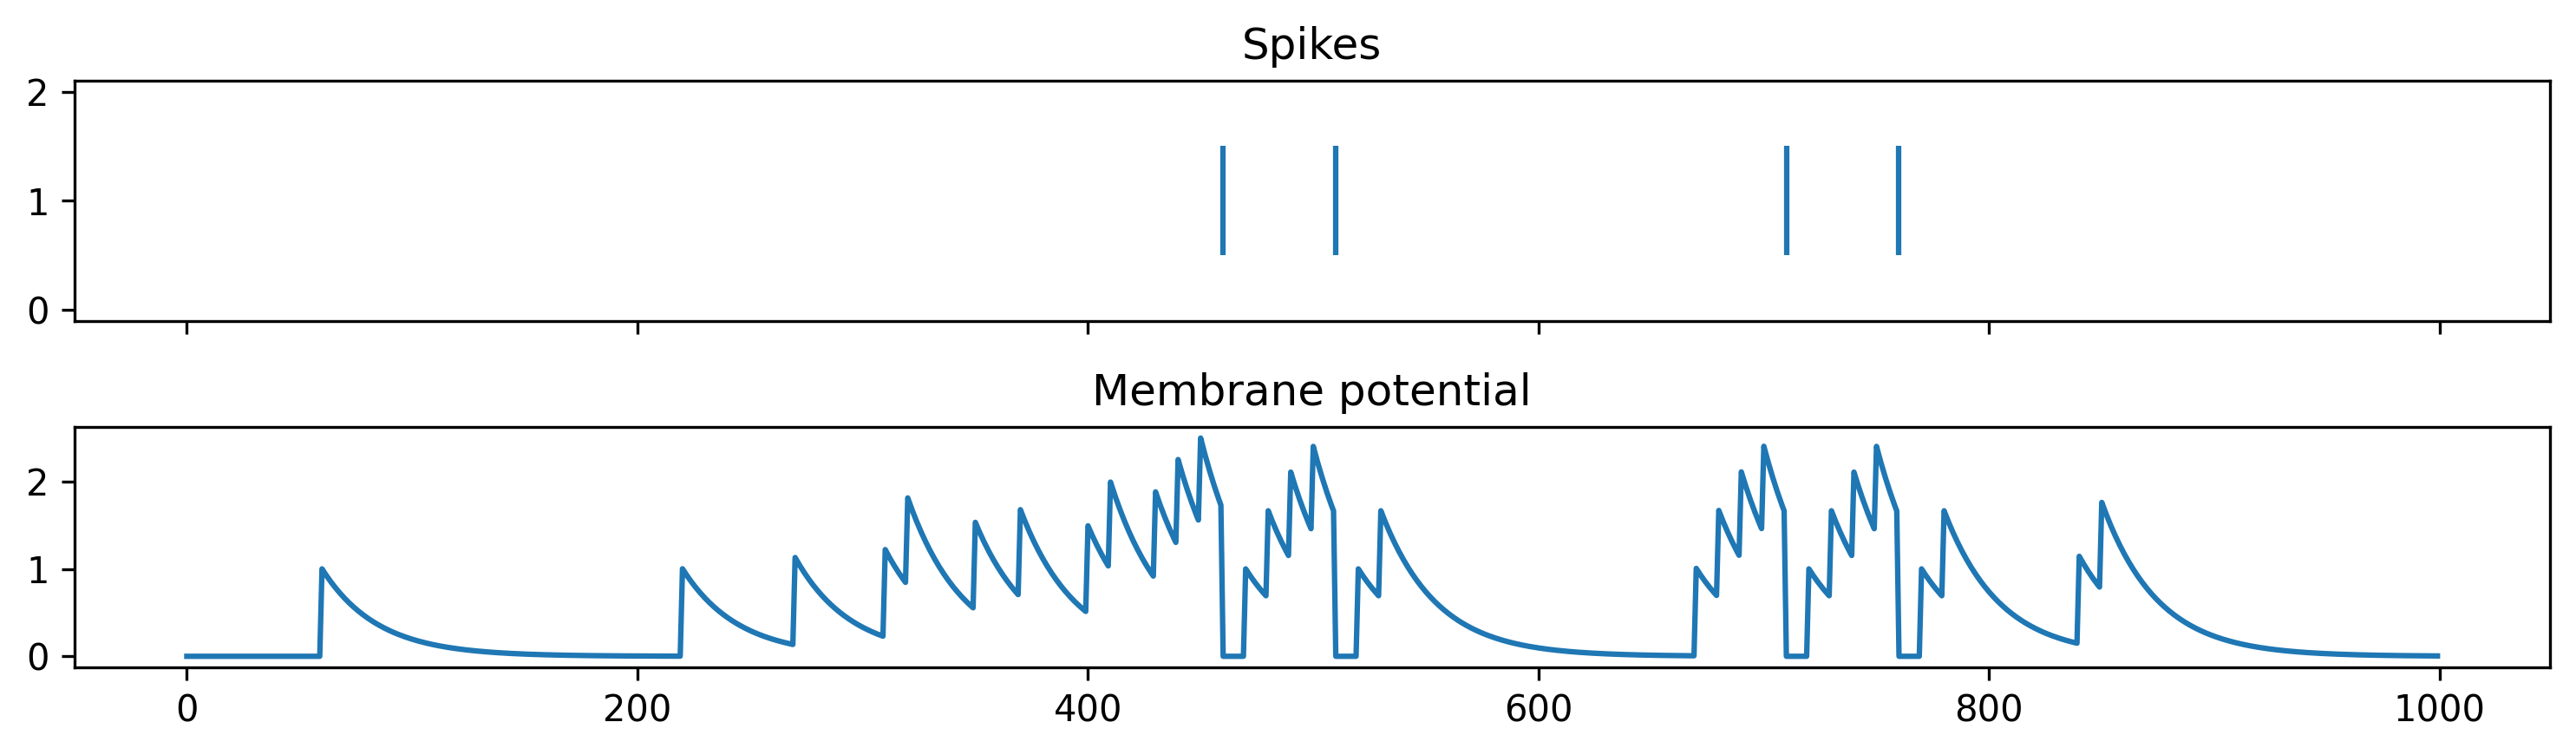

In [26]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 3), dpi=300)
axs[0].set_title('Spikes')
axs[0].eventplot(np.where(spk_arr == 1)[0])
axs[1].set_title('Membrane potential')
axs[1].plot(mem_arr)
plt.tight_layout();

In [8]:
with open(f'lif_snntorch.csv', 'w') as fw:
    for idx in range(d.shape[1]):
        fw.write(f'{d[0, idx]},{mem_arr[idx]},{spk_arr[idx]}\n')